<a href="https://colab.research.google.com/github/imitusov/ieee-fraud-detection/blob/master/ieee-fraud-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environemnt


**FUTURE POINTS**

---
**MODEL**
* Domain mismatch, adversarial validation and 'get_object_importance' for CatBoost
* Try different sampling approaches: undersampling or oversampling
* Use several CV schemes
* CV and public LB validation scores correlation graph
* Apply different imputation strategies depending on share of missing values
* Plot outliers indices that have been identified by different methods

**CODE**
* Decorator for NestedCrossValIntervals class

In [0]:
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%xmode Plain
%pdb off
clear_output()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
clear_output()

In [0]:
from google.colab import files
uploaded = files.upload()
clear_output()

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 
 
!pip install -q imbalanced-learn # Different sampling techniques
!pip install -q Boruta # Feature selection methods
!pip install -q category_encoders # Target encdoing 
!pip install -q pydrive
!pip install -q catboost
!pip install -q bayesian-optimization 
!pip install -q datawig # NaN's imputation
!pip install -q impyute # NaN's imputation
!pip install -q missingno # Missing data visualization
clear_output()

In [0]:
# Change root to target folder
import os
root_path = '/content/gdrive/My Drive/Colab Notebooks/IEEE (Kaggle)/'
os.chdir(root_path)

## Upload data

In [6]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore')
import os
import random
import imports
import re
from tqdm import tqdm
from typing import List
import dama as dm
import numpy as np
import scipy as sp
import scipy.stats as sst
import statsmodels as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datawig
import impyute
import datetime
import time
import pickle
import imblearn

# Models
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesRegressor, IsolationForest, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression 
import catboost as ctb
import lightgbm as lgb
import xgboost as xgb

# Preprocessing and feature creation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LassoCV, BayesianRidge, MultiTaskElasticNet, LogisticRegression
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.model_selection import TimeSeriesSplit, cross_val_score,\
StratifiedKFold, GridSearchCV, cross_validate
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis, FastICA, IncrementalPCA, LatentDirichletAllocation, \
TruncatedSVD
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score, silhouette_score, log_loss, make_scorer, matthews_corrcoef
from sklearn.feature_selection import SelectKBest 
from bayes_opt import BayesianOptimization
from boruta import BorutaPy
from fancyimpute import SoftImpute, KNN, IterativeImputer
import missingno as msno


# Category encoders
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders import JamesSteinEncoder

import multiprocessing as mp
from numba import jit
from scipy.stats import rankdata
import gc
seed_value = 31
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

%matplotlib inline

Using TensorFlow backend.
2019-10-14 16:48:11,941 [INFO]  NumExpr defaulting to 4 threads.


#### Upload files

In [7]:
%%time
# Upload premodified files
X_train = pd.read_csv(f'{root_path}x_train.csv', index_col=[0])
X_test = pd.read_csv(f'{root_path}x_test.csv', index_col=[0])
y_train = pd.read_csv(f'{root_path}y_train.csv', header=[0], index_col=[0])
y_test_id = pd.read_csv(f'{root_path}y_test_id.csv', header=None, index_col=[0], names=['TransactionID'])
# validation_scores = pd.read_csv(f'{root_path}validation_scores.csv', index_col=[0]) # currently outdated files
cat_cols = pd.read_csv(f'{root_path}cat_cols.csv', header=None, index_col=[0])[1].tolist()
number_cols = pd.read_csv(f'{root_path}number_cols.csv', header=None, index_col=[0])[1].tolist()

# Set up category columns
X_train.loc[:, cat_cols] = X_train.loc[:, cat_cols].astype(int)
X_test.loc[:, cat_cols] = X_test.loc[:, cat_cols].astype(int)

CPU times: user 1min 10s, sys: 7.3 s, total: 1min 17s
Wall time: 1min 40s


### Basic files

In [6]:
%%time
df_train_id = pd.read_csv(f'{root_path}train_identity.csv')
df_train_tr = pd.read_csv(f'{root_path}train_transaction.csv')
df_test_id = pd.read_csv(f'{root_path}test_identity.csv')
df_test_tr = pd.read_csv(f'{root_path}test_transaction.csv')
# Let's combine transaction and identity df's into one

X_train = pd.merge(df_train_tr, df_train_id, how='left', on='TransactionID')
X_test = pd.merge(df_test_tr, df_test_id, how='left', on='TransactionID' )
y_train = pd.DataFrame(X_train['isFraud'], columns=['isFraud'])
X_train.drop(['TransactionID'], axis=1, inplace=True)
X_test.drop(['TransactionID'], axis=1, inplace=True)
X_train.drop(['isFraud'], axis=1, inplace=True)
print(X_train.shape, X_test.shape)
del df_train_id, df_train_tr, df_test_id, df_test_tr

(590540, 432) (506691, 432)
CPU times: user 1min 3s, sys: 15.1 s, total: 1min 18s
Wall time: 1min 19s


# Prepare data

## Feature extraction

In [7]:
# Extract Time Feature

START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

def set_time(df: pd.DataFrame):
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds=x)))
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_hour'] = df['DT_hour'].astype('object')
    df['DT_day'] = df['DT'].dt.day
    df['DT_day'] = df['DT_day'].astype('object')
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day_week'] = df['DT_day_week'].astype('object')
    df.drop(['TransactionDT', 'DT'], axis=1, inplace=True)

set_time(X_train), set_time(X_test)

(None, None)

In [8]:
# Feature extraction 
def browser_split(row):
    if row is not np.nan:
        if row.split(' ')[0] != 'mobile':
            return row.split(' ')[0]
        else:
            try:
                return row.split(' ')[1]
            except IndexError:
                return row.split(' ')[0]

def version_split(row):
    if row is not np.nan:
        return re.sub('[^0-9.]', '', row)

def os_version_split(row):
    if row is not np.nan:
        if row.split(' ')[0] != 'Mac':
            try:
                return row.split(' ')[1]
            except IndexError:
                return np.nan
        else:
            return re.sub('[^0-9]', '', row).replace('.', '')

def int_to_str(df, cols):
    for col in cols:
        df[col] = df[col].astype('object')

def feature_split(df: pd.DataFrame):
    df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)
    df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = df['R_emaildomain'].str.split('.', expand=True)
    df['is_P_proton'] = df['P_emaildomain'].str.contains('proton', na=False).replace({True: 1, False: 0})
    df['is_P_mail'] = df['P_emaildomain'].str.match('mail', na=False).replace({True: 1, False: 0})
    df['is_P_outlook'] = df['P_emaildomain'].str.contains('outlook', na=False).replace({True: 1, False: 0})
    df['is_R_proton'] = df['R_emaildomain'].str.contains('proton', na=False).replace({True: 1, False: 0})
    df['is_R_mail'] = df['R_emaildomain'].str.match('mail', na=False).replace({True: 1, False: 0})
    df['is_R_outlook'] = df['R_emaildomain'].str.contains('outlook', na=False).replace({True: 1, False: 0})
    #df['is_P_proton'] = df['P_emaildomain_1'].apply(lambda x: 1 if x == 'protonmail' else 0)
    #df['is_P_mail'] = df['P_emaildomain_1'].apply(lambda x: 1 if x == 'mail' else 0)
    #df['is_P_outlook'] = df['P_emaildomain_1'].apply(lambda x: 1 if x == 'outlook' else 0)
    #df['is_R_proton'] = df['R_emaildomain_1'].apply(lambda x: 1 if x == 'protonmail' else 0)
    #df['is_R_mail'] = df['R_emaildomain_1'].apply(lambda x: 1 if x == 'mail' else 0)
    #df['is_R_outlook'] = df['R_emaildomain_1'].apply(lambda x: 1 if x == 'outlook' else 0)

    df['OS_id_30'] = df['id_30'].str.split(' ', expand=True)[0]
    df['version_id_30'] = df['id_30'].apply(os_version_split)
    df['browser_id_31'] = df['id_31'].apply(browser_split)
    df['version_id_31'] = df['id_31'].apply(version_split).replace('', 0).astype(np.float)*10
    df['screen_width'] = df['id_33'].str.split('x', expand=True)[0]
    df['screen_height'] = df['id_33'].str.split('x', expand=True)[1]
    df['id_34'] = df['id_34'].str.split(':', expand=True)[1]
    df['id_23'] = df['id_23'].str.split(':', expand=True)[1]

    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]
    df['device_version'] = df['DeviceInfo'].str.split('/', expand=True)[1]
    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
    df.drop(['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo'], axis=1, inplace=True)
    cols_to_str = ['OS_id_30', 'browser_id_31', 'id_34', 'version_id_30', 'version_id_31',
                   'screen_width', 'screen_height', 'device_name', 'device_version',
                   'is_P_proton', 'is_P_mail', 'is_P_outlook',
                   'is_R_proton', 'is_R_mail', 'is_R_outlook'] + df.select_dtypes(include='object').columns.to_list()
    df.loc[:, cols_to_str] = df.loc[:, cols_to_str].replace({None: np.nan})
    int_to_str(df, cols_to_str)

feature_split(X_train), feature_split(X_test)

(None, None)

### Columns dtypes


In [0]:
cat_cols = X_train.select_dtypes(include=['object']).columns.to_list()
number_cols = X_train.select_dtypes(include=['number']).columns.to_list()
assert(len(cat_cols) + len(number_cols) == X_train.shape[1])

## Cross validation scheme

Type - Nested

Intervals - based on month

Downsampling - True

The idea behind [downsampling](https://www.kaggle.com/c/ieee-fraud-detection/discussion/108616#latest-628955) - our model should find anomalies among normal transactions but reduced amount of normal transactions don't affect anomalies.




In [0]:
class NestedCrossValIntervals():

    def __init__(self, X, y, train_size=None, sample_size=None):
        self.X = X 
        self.y = y
        self.points = None
        self.samples = False
        self.train_size = 0.7 # Proportion for train/validation split
        self.sample_size = 8 # Number of normal incidicies per 1 fraud
        self.with_validation = None # Indicies with validation split
        self.no_validation = None #Indicies with out validation split
        
    def set_points(self):
        self.points = []
        for counter in range(self.X.shape[0] - 1):
            if self.X.loc[counter, 'DT_day'] > self.X.loc[counter + 1, 'DT_day']:
                self.points.append(counter + 1)
        self.points.append(self.X.shape[0] - 1)     
    
    def set_intervals(self):
        self.with_validation = []
        self.no_validation = []
        indices = np.arange(self.X.shape[0])
        if self.points is None:
            self.set_points()
        for idx in range(len(self.points) - 1):
            train = round(self.points[idx] * self.train_size)
            val = self.points[idx]
            test = self.points[idx + 1]
            self.with_validation.append([indices[0: train], indices[train: val], indices[val: test]])
            self.no_validation.append([indices[0: val], indices[val: test]])

    def set_samples(self):
        if self.samples is False:
            self.samples = True
            if self.with_validation is None:
                self.set_intervals()
            np.random.seed(seed_value)
            for interval in [self.with_validation, self.no_validation]:
                for idx in range(len(interval)):
                    indicies = interval[idx][0]
                    y_train = self.y.loc[indicies]
                    fraud_number = len(y_train[y_train['isFraud'] == 1])
                    fraud_indicies = y_train[y_train['isFraud'] == 1].index.values
                    normal_indicies = y_train[y_train['isFraud'] == 0].index.values
                    random_normal_indicies = np.random.choice(normal_indicies, fraud_number * self.sample_size, replace=False)
                    interval[idx][0] = np.union1d(random_normal_indicies, fraud_indicies)
        else:
            pass
        
    def split(self, validation=False, one_fold=False):
        """
        Yield a train/test indicies
        
        :param validation:
            whether to yield indicies for validation
        :param one_fold:
            to speed up perform 1 fold split, where last month is for test and all
            previous dates for train
        :return:
            yield indicies for train/validation/test sets respectively
        """
        if self.samples is False:
            self.set_samples()
        if validation is False:
            if one_fold is False:
                for idx in self.no_validation:
                    yield (idx[0], idx[1])
            else:
                yield self.no_validation[4][0], self.no_validation[4][1]
        else:
            if one_fold is False:
                for idx in self.with_validation:
                    yield idx[0], idx[1], idx[2]
            else:
                yield self.with_validation[4][0], self.with_validation[4][1], self.with_validation[4][2]

intervals = NestedCrossValIntervals(X_train, y_train)

In [0]:
# Train-val score calculations for LGBM and CTB

def train_val_score_lgbm(df, target, one_fold=False):
    param = {
        'objective': 'binary',
        'num_iterations': 200,
        'learning_rate': 0.05,
        'n_jobs': -1,
        'reg_alpha': 0.1,
        'min_split_gain': 0.1,
        'bagging_fraction': 0.5,
        'bagging_freq': 5,
        'pos_bagging_fraction': 0.5,
        'neg_bagging_fraction': 0.5,
        'feature_fraction': 0.5,
        'verbose': -1,
        'metric': ['auc', 'binary_logloss']
    }
    auc_score = []
    df_ = df.copy()
    target_ = target.copy()
    df_.reset_index(drop=True, inplace=True)
    target_.reset_index(drop=True, inplace=True)
    intervals = NestedCrossValIntervals(df_, target_)
    for train_index, val_index in intervals.split(one_fold=one_fold):
        train_data = lgb.Dataset(df_.loc[train_index], label=target_.loc[train_index],
                                 feature_name=df.columns.to_list(), categorical_feature=cat_cols)
        validation_data = lgb.Dataset(df_.loc[val_index], label=target_.loc[val_index], feature_name=df.columns.to_list(),
                                    categorical_feature=cat_cols, reference=train_data)
        bst = lgb.train(param, train_data, valid_sets=[train_data, validation_data], feval=mcc_eval, verbose_eval=False)
        auc_score.append(round(bst.best_score['valid_1']['auc'], 4))
    print(f'Average LGBM score is: {round(sum(auc_score)/len(auc_score), 4)}; CV-fold scores are: {auc_score}')

def train_val_score_catboost(df, target, one_fold=False):
    param = {
        'iterations': 200,
        'learning_rate': 0.1,
        'loss_function': 'Logloss',
        'custom_metric': ['AUC'],
        'random_seed': 31,
        'l2_leaf_reg': 3,
        'depth': 7,
        'one_hot_max_size': 5,
        'rsm': 0.5,
    }
    auc_score = []
    df_ = df.copy()
    target_ = target.copy()
    df_.reset_index(drop=True, inplace=True)
    target_.reset_index(drop=True, inplace=True)
    intervals = NestedCrossValIntervals(df_, target_)
    for train_index, val_index in intervals.split(one_fold=one_fold):
        train_data = ctb.Pool(df_.loc[train_index, :], label=target_.loc[train_index, :],
                              cat_features=cat_cols, feature_names=df_.columns.to_list())
        validation_data = ctb.Pool(df_.loc[val_index, :], label=target_.loc[val_index, :],
                              cat_features=cat_cols, feature_names=df_.columns.to_list())
        pos_neg_weight = len(np.where(target_.loc[train_index] == 0)[0]) / len(np.where(target_.loc[train_index] == 1)[0])
        param['class_weights'] = [1, pos_neg_weight]
        model = ctb.CatBoostClassifier(**param, logging_level='Silent')
        model.fit(train_data, eval_set=validation_data)
        metrics = model.eval_metrics(validation_data, ['AUC'], eval_period=1)
        auc_score.append(round(np.array(metrics['AUC']).max(), 4))
    print(f'Average CTB score is: {round(sum(auc_score)/len(auc_score), 4)}; CV-fold scores: {auc_score}')

## Custom Loss (MCC)

In [0]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc
    
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc, True

## Transformations (for numeric columns)

Yeo-Jonhson and RobustScaler



### Yeo-Johnson Transformation

In [14]:
# Apply Yeo-Johnson transformation
%%time
yeo_cols = ['TransactionAmt'] + X_train.loc[:, 'C1':'C14'].columns.to_list()
robust_cols = [x for x in number_cols if x not in yeo_cols]
def yeo_johnson_transformation(df_train: pd.DataFrame, df_test: pd.DataFrame, cols=List[str]):
    for col in cols:
        df_train[col], alpha = sst.yeojohnson(df_train[col].astype(np.float))
        df_test[col] = sst.yeojohnson(df_test[col].astype(np.float), alpha)

yeo_johnson_transformation(X_train, X_test, yeo_cols)

CPU times: user 17.5 s, sys: 85.3 ms, total: 17.6 s
Wall time: 17.6 s


### Robust Scaler

In [15]:
%%time
scaler = RobustScaler()
def robust_scalar(df_train: pd.DataFrame, df_test: pd.DataFrame, cols=List[str]):
    df_train[cols] = scaler.fit_transform(df_train[cols])
    df_test[cols] = scaler.transform(df_test[cols])

robust_scalar(X_train, X_test, robust_cols)

CPU times: user 1min 2s, sys: 6.85 s, total: 1min 9s
Wall time: 1min 9s


## Label encoder

Remove rare cats and LabelEncoding


### Remove rare categories

In [0]:
# Remove rare categories
def value_counts_remove(df_train: pd.DataFrame, df_test: pd.DataFrame, cols=List[str]):
    for col in cols:
        tmp = df_train[col].value_counts()[df_train[col].value_counts() < 20].index
        df_train.loc[df_train[col].isin(tmp), col] = 'rare'
        df_test.loc[df_test[col].isin(tmp), col] = 'rare' 
value_counts_remove(X_train, X_test, cat_cols)

### Encoding

In [17]:
%%time
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in set(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

def label_encoder(df_train: pd.DataFrame, df_test: pd.DataFrame, cols=List[str]):
    for col in cols:
        le = LabelEncoderExt()
        #df_train.loc[~df_train[col].isin([np.nan]), col] = df_train.loc[~df_train[col].isin([np.nan]), col].astype(str)
        #df_test.loc[~df_test[col].isin([np.nan]), col] = df_test.loc[~df_test[col].isin([np.nan]), col].astype(str)
        le.fit(df_train.loc[~df_train[col].isin([np.nan]), col].values)
        df_train.loc[~df_train[col].isin([np.nan]), col] = le.transform(df_train.loc[~df_train[col].isin([np.nan]), col])
        df_test.loc[~df_test[col].isin([np.nan]), col] = le.transform(df_test.loc[~df_test[col].isin([np.nan]), col])

cols_to_encode = [x for x in cat_cols if x not in ['DT_hour', 'DT_day', 'DT_day_week']]
label_encoder(X_train, X_test, cols_to_encode)

CPU times: user 35.2 s, sys: 432 ms, total: 35.7 s
Wall time: 35.7 s


## Comparison of classifiers and Baseline model
CatBoost and LGBM provided good results in term of both training bias and test variance. Also RF, AdaBoost, and LDA provided comparable public score.

Baseline score LGBM - **0.9006** 

Baseline score CTB -  **0.9008**

*Model* - LGBM 

*CV* - 5-fold TimeSeries crossval scheme defined with NestedCrossValIntervals

*Metric* - AUC as eval metric

Seems like bigger training sets results in a higher validation score for CTB 

### GBM classifiers

In [18]:
# Simple filling of missing median for cont variables and mode for cat variables

def fill_missings(df_train, df_test):
    df_train_1 = df_train.copy()
    df_test_1 = df_test.copy()

    for col in number_cols: 
        df_train_1[col] = df_train_1[col].fillna(df_train_1[col].median())
        df_test_1[col] = df_test_1[col].fillna(df_train_1[col].median())    
    
    for col in cat_cols:
        df_train_1[col] = df_train_1[col].fillna(-1)
        df_test_1[col] = df_test_1[col].fillna(-1)
    return df_train_1, df_test_1
    
X_train_m, X_test_m = fill_missings(X_train, X_test)

# Scores for GBM models 
train_val_score_lgbm(X_train_m, y_train)
train_val_score_catboost(X_train_m, y_train)

Average LGBM score is: 0.9006; CV-fold scores are: [0.8882, 0.9052, 0.9006, 0.9026, 0.9065]
Average CTB score is: 0.9008, CV-fold scores: [0.884, 0.9034, 0.8979, 0.907, 0.9118]


### Sklearn classifiers

In [0]:
%%time
# Scores for basic sklearn classifiers 
clf_names = ['RF', 'ABC', 'GNB', 'QDA',
             #'GPC', 'SVC_LIN', 'SVC_RBF', 'NN',
             'LDA', 'LR'
             ]

# SVM classifiers are too long to train. Complexity is about O(n^3): reduce C, no kernel, dimension reduction techniques

classifiers = [
               RandomForestClassifier(max_depth=6, max_features='sqrt', n_estimators=30),
               AdaBoostClassifier(),
               GaussianNB(),
               QuadraticDiscriminantAnalysis(reg_param=0.1),
               #GaussianProcessClassifier(1.0 * RBF(1.0)),
               #SVC(kernel='linear', C=0.025),
               #SVC(gamma=2, C=1),
               #MLPClassifier(alpha=1, max_iter=10),
               LinearDiscriminantAnalysis(),
               LogisticRegression(class_weight='balanced')
               ]

intervals = NestedCrossValIntervals(X_train_m, y_train)
scoring = {'AUC': make_scorer(roc_auc_score),
           'Log_loss': make_scorer(log_loss)}

clf_nested_scores = {}
for name, clf in zip(clf_names, classifiers):
    nested_scores = cross_validate(clf, X_train_m, y_train, return_train_score=True,
                               n_jobs=-1, cv=intervals.split(), scoring=scoring,
                               return_estimator=True, verbose=1)
    for idx, estimator in enumerate(nested_scores['estimator']):
        bst = estimator
        y_test = bst.predict_proba(X_test_m)
        submission = np.column_stack((y_test_id['TransactionID'], y_test))
        submission = pd.DataFrame(submission, columns=['TransactionID', 'N', 'isFraud'])
        submission.drop('N', axis=1, inplace=True)
        submission['TransactionID'] = submission['TransactionID'].astype(int) 
        submission.to_csv(f'{root_path}submission.csv', index=False)
        !kaggle competitions submit -c ieee-fraud-detection -f '{root_path}submission.csv' -m "{name}_model_{idx}"
    del nested_scores['estimator']
    clf_nested_scores[name] = nested_scores

In [0]:
%%time
# Scores for LGBM
param = {
'objective': 'binary',
'num_iterations': 200,
'learning_rate': 0.05,
'n_jobs': -1,
'reg_alpha': 0.1,
'min_split_gain': 0.1,
'bagging_fraction': 0.5,
'bagging_freq': 5,
'pos_bagging_fraction': 0.5,
'neg_bagging_fraction': 0.5,
'feature_fraction': 0.5,
'verbose': 0,
'metric': ['auc', 'binary_logloss']
}

lgbm_scores = {}
lgbm_scores['lgbm'] = {}
lgbm_scores['lgbm']['test_AUC'] = []
lgbm_scores['lgbm']['test_Log_loss'] = []
lgbm_scores['lgbm']['train_AUC'] = []
lgbm_scores['lgbm']['train_Log_loss'] = []

for idx, (train_index, val_index) in enumerate(intervals.split()):
    train_data = lgb.Dataset(X_train_m.loc[train_index], label=y_train.loc[train_index], feature_name=X_train_m.columns.to_list(),
                                categorical_feature=cat_cols)
    validation_data = lgb.Dataset(X_train_m.loc[val_index], label=y_train.loc[val_index], feature_name=X_train_m.columns.to_list(),
                                    categorical_feature=cat_cols, reference=train_data)
    bst = lgb.train(param, train_data, valid_sets=[train_data, validation_data], verbose_eval=200)
    lgbm_scores['lgbm']['test_AUC'].append(bst.best_score['valid_1']['auc'])
    lgbm_scores['lgbm']['test_Log_loss'].append(bst.best_score['valid_1']['binary_logloss'])
    lgbm_scores['lgbm']['train_AUC'].append(bst.best_score['training']['auc'])
    lgbm_scores['lgbm']['train_Log_loss'].append(bst.best_score['training']['binary_logloss'])
    y_test = bst.predict(X_test_m)
    submission = np.vstack([y_test_id['TransactionID'], y_test])
    submission = pd.DataFrame(submission.T, columns=['TransactionID', 'isFraud'])
    submission['TransactionID'] = submission['TransactionID'].astype(int) 
    submission.to_csv(f'{root_path}submission.csv', index=False)
    !kaggle competitions submit -c ieee-fraud-detection -f '{root_path}submission.csv' -m "lgbm_model_{idx}"

In [0]:
%%time
# Scores for CatBoost
param = {
    'iterations': 200,
    'depth': 8,
    'learning_rate': 0.05,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'has_time': True,
    'rsm': 0.5,
    'class_weights': [0.2, 2],
    'metric_period': 200
    }

ctb_scores = {}
ctb_scores['ctb'] = {}
ctb_scores['ctb']['test_AUC'] = []
ctb_scores['ctb']['test_Log_loss'] = []
ctb_scores['ctb']['train_AUC'] = []
ctb_scores['ctb']['train_Log_loss'] = []

for idx, (train_index, val_index) in enumerate(intervals.split()):
    train_data = ctb.Pool(X_train_m.loc[train_index], label=y_train.loc[train_index],
                          feature_names=X_train_m.columns.to_list(), cat_features=cat_cols)
    validation_data = ctb.Pool(X_train_m.loc[val_index], label=y_train.loc[val_index],
                               feature_names=X_train_m.columns.to_list(), cat_features=cat_cols)
    bst = ctb.CatBoostClassifier(**param)
    bst.fit(train_data, eval_set=[(train_data), (validation_data)])
    ctb_scores['ctb']['test_AUC'].append(bst.get_best_score()['validation_1']['AUC'])
    ctb_scores['ctb']['test_Log_loss'].append(bst.get_best_score()['validation_1']['Logloss'])
    ctb_scores['ctb']['train_AUC'].append(bst.get_best_score()['validation_0']['AUC'])
    ctb_scores['ctb']['train_Log_loss'].append(bst.get_best_score()['validation_0']['Logloss'])
    y_test = bst.predict_proba(X_test_m)
    submission = np.column_stack((y_test_id['TransactionID'], y_test))
    submission = pd.DataFrame(submission, columns=['TransactionID', 'N', 'isFraud'])
    submission.drop('N', axis=1, inplace=True)
    submission['TransactionID'] = submission['TransactionID'].astype(int) 
    submission.to_csv(f'{root_path}submission.csv', index=False)
    !kaggle competitions submit -c ieee-fraud-detection -f '{root_path}submission.csv' -m "ctb_model_{idx}"

In [0]:
# Remove unnecessary info
for i in clf_nested_scores:
    del clf_nested_scores[i]['fit_time']
    del clf_nested_scores[i]['score_time']

del X_train_m, X_test_m

# Union dicts
overall_scores = {**ctb_scores, **lgbm_scores, **clf_nested_scores}

# Add info about public LB and private LB
overall_scores['ctb']['private_score'] = np.array([0.860507, 0.870847, 0.880731, 0.886185, 0.891070])
overall_scores['ctb']['public_score'] = np.array([0.883710, 0.896797, 0.903107, 0.906419, 0.914127])

overall_scores['lgbm']['private_score'] = np.array([0.871282, 0.886129, 0.891975, 0.895380, 0.900907]) 
overall_scores['lgbm']['public_score'] = np.array([0.884374, 0.900157, 0.905878, 0.909609, 0.914932])

overall_scores['RF']['private_score'] = np.array([0.855268, 0.851583, 0.851114, 0.853279, 0.855679])
overall_scores['RF']['public_score'] = np.array([0.870481, 0.874063, 0.872924, 0.874627, 0.877253])

overall_scores['ABC']['private_score'] = np.array([0.837474, 0.850935, 0.854135, 0.858698, 0.865734])
overall_scores['ABC']['public_score'] = np.array([0.856489, 0.869580, 0.877324, 0.877096, 0.884482])

overall_scores['GNB']['private_score'] = np.array([0.706702, 0.729024, 0.751446, 0.759326, 0.738894])
overall_scores['GNB']['public_score'] = np.array([0.742798, 0.778444, 0.803641, 0.816373, 0.803525])

overall_scores['QDA']['private_score'] = np.array([0.765870, 0.786288, 0.790343, 0.796831, 0.795237])
overall_scores['QDA']['public_score'] = np.array([0.794867, 0.813645, 0.820001, 0.827473, 0.829351])

overall_scores['LDA']['private_score'] = np.array([0.810928, 0.829173, 0.840200, 0.848459, 0.849301])
overall_scores['LDA']['public_score'] = np.array([0.838113, 0.865900, 0.874981, 0.878271, 0.880797])

overall_scores['LR']['private_score'] = np.array([0.758811, 0.772954, 0.762239, 0.775179, 0.767541])
overall_scores['LR']['public_score'] = np.array([0.792295, 0.813102, 0.808237, 0.818675, 0.812328])

# Constract a frame
overall_frame = pd.concat({k: pd.DataFrame(v).T for k, v in overall_scores.items()}, axis=0)
overall_frame_melt = pd.melt(overall_frame.reset_index(), id_vars=['level_0', 'level_1'], value_vars=[0, 1, 2, 3, 4])

In [0]:
# Remove Logloss - messes values from different scores
overall_frame_melt = overall_frame_melt[(overall_frame_melt['level_1'] != 'test_Log_loss') & (overall_frame_melt['level_1'] != 'train_Log_loss')]

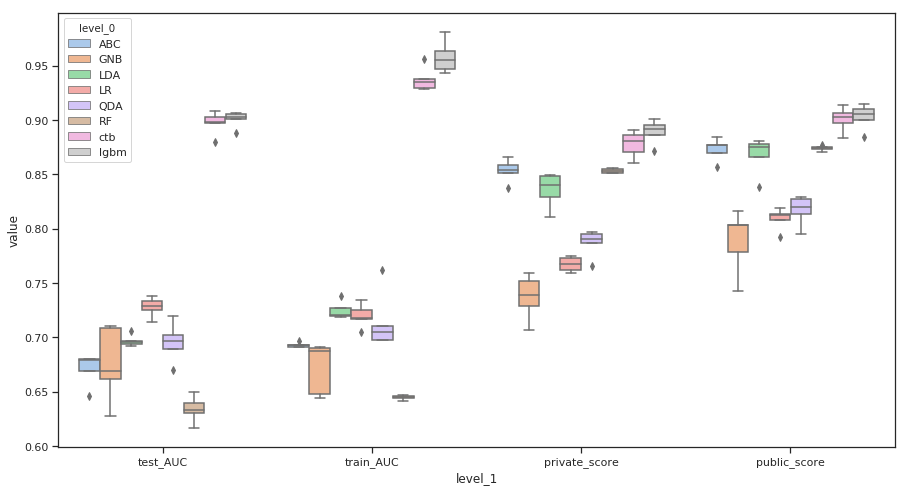

In [0]:
# Bias and variance of different models
plt.figure(figsize=(15, 8))
sns.set(style="ticks", palette="pastel")
sns.boxplot(data=overall_frame_melt, x='level_1', y='value', hue='level_0', dodge=True)

## Missing values
After imputation cv-scores are:

LGBM - **0.9015**

CTB - **0.9010**


### Imputation for numeric columns

Ideas:
*   Apply different imputation strategies depending on share of missing values
*   Enhance IterativeImputation approach
*   Enhance interpolation approach  
*   For time-depended features select and appropriate method to fill (currently not)
*   Check Autoimpute library



In [0]:
# Divide numeric columns for 2 categories: more than 50% of missing and less 

missings = X_train.loc[:, number_cols].isna().sum() / X_train.shape[0]
df_missings = pd.DataFrame({'column_name': X_train.loc[:, number_cols].columns,
                            'percent_missing': missings})
df_missings.sort_values('percent_missing', inplace=True, ascending=False)
df_missings.reset_index(drop=True, inplace=True)
number_cols_low_miss = df_missings[df_missings['percent_missing'] < 0.5]['column_name'].to_list()
number_cols_high_miss = df_missings[df_missings['percent_missing'] >= 0.5]['column_name'].to_list()

#### Basic imputation strategies: median, mean, mode 

Median approach provided the best result

In [0]:
# Score with 'median' imputation - 0.9006
def fill_median(df, number, cat):
    df_ = df.copy()
    for col in number:
        df_[col] = df_[col].fillna(df_[col].median())
    for col in cat:
        df_[col] = df_[col].fillna(-1)
    return df_

X_train_median = fill_median(X_train, number_cols, cat_cols)
train_val_score(X_train_median, y_train)
del X_train_median

[200]	training's binary_logloss: 0.113486	training's auc: 0.980652	training's MCC: 0.833439	valid_1's binary_logloss: 0.117421	valid_1's auc: 0.888216	valid_1's MCC: 0.546223
[200]	training's binary_logloss: 0.135803	training's auc: 0.963629	training's MCC: 0.778239	valid_1's binary_logloss: 0.110033	valid_1's auc: 0.905209	valid_1's MCC: 0.56167
[200]	training's binary_logloss: 0.143435	training's auc: 0.954813	training's MCC: 0.759988	valid_1's binary_logloss: 0.112111	valid_1's auc: 0.900636	valid_1's MCC: 0.532242
[200]	training's binary_logloss: 0.152605	training's auc: 0.94641	training's MCC: 0.732573	valid_1's binary_logloss: 0.106191	valid_1's auc: 0.902617	valid_1's MCC: 0.510135
[200]	training's binary_logloss: 0.15631	training's auc: 0.943459	training's MCC: 0.722829	valid_1's binary_logloss: 0.110589	valid_1's auc: 0.906454	valid_1's MCC: 0.527245
0.9006263287657911


(<lightgbm.basic.Booster at 0x7fc226131320>, None)

In [0]:
# Score with 'mean' imputation - 0.8996
def fill_mean(df, number, cat):
    df_ = df.copy()
    for col in number:
        df_[col] = df_[col].fillna(df_[col].mean())
    for col in cat:
        df_[col] = df_[col].fillna(-1)
    return df_

X_train_mean = fill_mean(X_train, number_cols, cat_cols)
train_val_score(X_train_mean, y_train)
del X_train_mean

[200]	training's binary_logloss: 0.112997	training's auc: 0.981241	training's MCC: 0.830781	valid_1's binary_logloss: 0.11892	valid_1's auc: 0.885576	valid_1's MCC: 0.537573
[200]	training's binary_logloss: 0.135709	training's auc: 0.963215	training's MCC: 0.779248	valid_1's binary_logloss: 0.110008	valid_1's auc: 0.906304	valid_1's MCC: 0.56184
[200]	training's binary_logloss: 0.143626	training's auc: 0.953785	training's MCC: 0.758853	valid_1's binary_logloss: 0.113628	valid_1's auc: 0.897169	valid_1's MCC: 0.53083
[200]	training's binary_logloss: 0.15285	training's auc: 0.946339	training's MCC: 0.732326	valid_1's binary_logloss: 0.107263	valid_1's auc: 0.901274	valid_1's MCC: 0.499937
[200]	training's binary_logloss: 0.156359	training's auc: 0.943465	training's MCC: 0.724836	valid_1's binary_logloss: 0.109629	valid_1's auc: 0.907861	valid_1's MCC: 0.532783
0.8996367255736679


In [0]:
# Score with 'mode' imputation - 0.9000
def fill_mode(df, number, cat):
    df_ = df.copy()
    for col in number:
        df_[col] = df_[col].fillna(df_[col].mode())
    for col in cat:
        df_[col] = df_[col].fillna(-1)
    return df_

X_train_mode = fill_mode(X_train, number_cols, cat_cols)
train_val_score(X_train_mode, y_train)
del X_train_mode

[200]	training's binary_logloss: 0.111044	training's auc: 0.98187	training's MCC: 0.838251	valid_1's binary_logloss: 0.118072	valid_1's auc: 0.886406	valid_1's MCC: 0.546911
[200]	training's binary_logloss: 0.134034	training's auc: 0.965049	training's MCC: 0.781055	valid_1's binary_logloss: 0.109775	valid_1's auc: 0.905194	valid_1's MCC: 0.564645
[200]	training's binary_logloss: 0.142228	training's auc: 0.955838	training's MCC: 0.762563	valid_1's binary_logloss: 0.11265	valid_1's auc: 0.899416	valid_1's MCC: 0.530906
[200]	training's binary_logloss: 0.151851	training's auc: 0.948132	training's MCC: 0.733086	valid_1's binary_logloss: 0.106518	valid_1's auc: 0.902347	valid_1's MCC: 0.502867
[200]	training's binary_logloss: 0.155522	training's auc: 0.944065	training's MCC: 0.727122	valid_1's binary_logloss: 0.109617	valid_1's auc: 0.906855	valid_1's MCC: 0.525765
0.9000437037272422


#### Iterative imputation with BayesianRidge and ExtraTreeRegressor as an estimators

IterativeImputer shows a bit better score for large training sets in CV neveretheless average score is a bit lower.

May be considered as an alternative to median approach

In [0]:
%%time
# Score with 'ExtraTreeRegressor' imputation - 0.9004 (800, 80, 80, 1)
# Score with 'ExtraTreeRegressor' imputation - 0.9015 (800, 80, 1, 1) for features with low % of missing we use imputer, for others median


impute_estimator = ExtraTreesRegressor(min_samples_split=800, min_samples_leaf=80,
                                       max_features='sqrt', n_jobs=-1, bootstrap=True, max_depth=6, random_state=31)

# IterativeImputer's docs may change. 
imputer = IterativeImputer(predictor=impute_estimator,
                           n_nearest_features=1, initial_strategy='median',
                           n_iter=1, verbose=2, random_state=31)

def numerical_imputer(df: pd.DataFrame, number, number_high, cat):
    df_ = df.copy()
    for col in number_high:
        df_[col] = df_[col].fillna(df_[col].median())
    for col in cat:
        df_[col] = df_[col].fillna(-1)
    df_.loc[:, number] = imputer.fit_transform(df_.loc[:, number])
    return df_

X_train_imp = numerical_imputer(X_train, number_cols, number_cols_high_miss, cat_cols)
train_val_score(X_train_imp, y_train)
del X_train_imp

# Score with 'ExtraTreeRegressor' imputation - 0.9004 (800, 80, 80, 1) - Neveretheless the average score is a bit lower than for 'simple_median',
# later scores for higher train amount data are higher. Information leak? We fit imputer on the whole dataset.

# Some previous experiments with IterativeImputer. Old validation scheme has been used - 70/30 split with no shuffle.
# Score with 'BayesianRidge' imputation - 0.896087
# Score with 'ExtraTreeRegressor' imputation - 0.899197
# Score with 'ExtraTreeRegressor' imputation - 0.898846 (30 iterations, 10 features)
# Score with 'ExtraTreeRegressor' imputation - 0.899521 (2 iterations, 30 features)
# Score with 'ExtraTreeRegressor' imputation - 0.899611 (1 iteration, 100 features)
# Score with 'ExtraTreeRegressor' imputation - 0.901666 (same iteration params; increase min_sample_split (500 -> 1000), min_sample_leaf (50 -> 100), decrease max_depth (8 -> 6))
# Score with 'ExtraTreeRegressor' imputation - 0.900015 (3 iteration, 50 featrues; same tree params)
# Score with 'BayesianRidge' imputation - 0.899028 (1 iteration, 50 features; no model params)
# Score with 'ExtraTreeRegressor' imputation - 0.897818 (1 ieration, 150 features; (1500, 200, 8))
# Score with 'ExtraTreeRegressor' imputation - 0.902331 (800, 80, 80)

[IterativeImputer] Completing matrix with shape (590540, 448)
[IterativeImputer] Ending imputation round 1/1, elapsed time 65.23
[200]	training's binary_logloss: 0.113147	training's auc: 0.980535	training's MCC: 0.831051	valid_1's binary_logloss: 0.11791	valid_1's auc: 0.887117	valid_1's MCC: 0.552361
[200]	training's binary_logloss: 0.134684	training's auc: 0.964132	training's MCC: 0.780542	valid_1's binary_logloss: 0.11004	valid_1's auc: 0.906622	valid_1's MCC: 0.565466
[200]	training's binary_logloss: 0.143504	training's auc: 0.953775	training's MCC: 0.759757	valid_1's binary_logloss: 0.112592	valid_1's auc: 0.897338	valid_1's MCC: 0.534455
[200]	training's binary_logloss: 0.152929	training's auc: 0.946323	training's MCC: 0.730932	valid_1's binary_logloss: 0.106417	valid_1's auc: 0.903609	valid_1's MCC: 0.50489
[200]	training's binary_logloss: 0.155946	training's auc: 0.943182	training's MCC: 0.723421	valid_1's binary_logloss: 0.110996	valid_1's auc: 0.904555	valid_1's MCC: 0.526066

#### Interpolation

In [0]:
%%time
# Score with 'linear_interpolation' imputation - 0.8939 (22.5 min)
# Too long to calculate with other methods
def numerical_interpolation(df, number, cat):
    df_ = df.copy()
    for col in number:
        df_[number] = df_[number].interpolate(method='linear', axis=0, limit_direction='both')
    for col in cat:
        df_[col]  = df_[col].fillna(-1)
    return df_

X_train_inter = numerical_interpolation(X_train, number_cols, cat_cols)
train_val_score(X_train_inter, y_train)
del X_train_inter

#### Final imputation for numeric columns

In [22]:
# Final imputation for numeric features
impute_estimator = ExtraTreesRegressor(min_samples_split=800, min_samples_leaf=80,
                                       max_features='sqrt', n_jobs=-1, bootstrap=True, max_depth=6, random_state=31)
imputer = IterativeImputer(predictor=impute_estimator, n_nearest_features=1, initial_strategy='median',
                           n_iter=1, verbose=2, random_state=31)

for col in number_cols_high_miss:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_train[col].median())
X_train.loc[:, number_cols] = imputer.fit_transform(X_train.loc[:, number_cols])
X_test.loc[:, number_cols] = imputer.transform(X_test.loc[:, number_cols])

[IterativeImputer] Completing matrix with shape (590540, 400)
[IterativeImputer] Ending imputation round 1/1, elapsed time 60.56
[IterativeImputer] Completing matrix with shape (506691, 400)
[IterativeImputer] Ending imputation round 1/1, elapsed time 16.08


### Imputation for category columns

In [0]:
# Divide cat columns for 2 categories: more than 50% of missing and less 

missings_cat = X_train.loc[:, cat_cols].isna().sum() / X_train.shape[0]
df_missings_cat = pd.DataFrame({'column_name': X_train.loc[:, cat_cols].columns,
                            'percent_missing': missings_cat})
df_missings_cat.sort_values('percent_missing', inplace=True, ascending=False)
df_missings_cat.reset_index(drop=True, inplace=True)
cat_cols_low_miss = df_missings_cat[df_missings['percent_missing'] < 0.5]['column_name'].to_list()
cat_cols_high_miss = df_missings_cat[df_missings['percent_missing'] >= 0.5]['column_name'].to_list()

#### Fill with mode 

In [0]:
# Score with mode imputation - 0.9003
def fill_cat_mode(df, cat):
    df_ = df.copy()
    for col in cat:
        df_[col] = df_[col].fillna(df_[col].mode())
    return df_

X_train_catmode = fill_cat_mode(X_train, cat_cols)
train_val_score(X_train_catmode, y_train)
del X_train_catmode

[200]	training's binary_logloss: 0.112816	training's auc: 0.981483	training's MCC: 0.832315	valid_1's binary_logloss: 0.117396	valid_1's auc: 0.890249	valid_1's MCC: 0.546629
[200]	training's binary_logloss: 0.134268	training's auc: 0.964366	training's MCC: 0.780778	valid_1's binary_logloss: 0.109563	valid_1's auc: 0.905916	valid_1's MCC: 0.565672
[200]	training's binary_logloss: 0.142592	training's auc: 0.955305	training's MCC: 0.759822	valid_1's binary_logloss: 0.112552	valid_1's auc: 0.897347	valid_1's MCC: 0.531906
[200]	training's binary_logloss: 0.153001	training's auc: 0.946233	training's MCC: 0.73196	valid_1's binary_logloss: 0.106225	valid_1's auc: 0.901815	valid_1's MCC: 0.507158
[200]	training's binary_logloss: 0.156056	training's auc: 0.943733	training's MCC: 0.720733	valid_1's binary_logloss: 0.110496	valid_1's auc: 0.906087	valid_1's MCC: 0.526536
0.900282768971026


#### Fill with -999

In [0]:
# Score with '-1' imputation - 0.9015
# Score with '-1' imputation and flag columns - 0.8999

def fill_cat_999(df, cat):
    df_ = df.copy()
    for col in cat:
        df_[col + '_na'] = df_[col].isna()
        df_[col] = df_[col].fillna(-1)
    return df_

X_train_cat_999 = fill_cat_999(X_train, cat_cols)
train_val_score(X_train_cat_999, y_train)
del X_train_cat_999

[200]	training's binary_logloss: 0.111885	training's auc: 0.982164	training's MCC: 0.835327	valid_1's binary_logloss: 0.118492	valid_1's auc: 0.886258	valid_1's MCC: 0.545038
[200]	training's binary_logloss: 0.134292	training's auc: 0.965335	training's MCC: 0.780332	valid_1's binary_logloss: 0.109851	valid_1's auc: 0.905578	valid_1's MCC: 0.562959
[200]	training's binary_logloss: 0.143138	training's auc: 0.954807	training's MCC: 0.758583	valid_1's binary_logloss: 0.112765	valid_1's auc: 0.897879	valid_1's MCC: 0.529658
[200]	training's binary_logloss: 0.152607	training's auc: 0.946902	training's MCC: 0.73192	valid_1's binary_logloss: 0.106276	valid_1's auc: 0.902777	valid_1's MCC: 0.507448
[200]	training's binary_logloss: 0.15609	training's auc: 0.943386	training's MCC: 0.721876	valid_1's binary_logloss: 0.109845	valid_1's auc: 0.907096	valid_1's MCC: 0.530364
0.8999175454758734


#### Iterative imputation

In [0]:
# KNN predictor trains too long
# Score with 'ExtraTreeRegressor' imputation - 0.9005 (800, 80, 1, 1)
# Score with 'ExtraTreeRegressor' imputation with all columns - 0.9007 (800, 80, 1, 1)
# Score with 'ExtraTreeRegressor' imputation with all columns - 0.9009 (800, 80, 2, 1)
# Score with 'ExtraTreeRegressor' imputation with all columns - 0.9006 (800, 80, 10, 10) - good score for last fold (0.9104)
# Score with 'ExtraTreeRegressor' imputation with all columns - 0.8990 (800, 80, 10, 1) 
# Score with 'ExtraTreeRegressor' imputation with all columns - 0.9001 (800, 80, 3, 1) 
# Score with 'ExtraTreeRegressor' imputation with all columns - 0.9004 (800, 80, 2, 10) 


impute_estimator = ExtraTreesRegressor(min_samples_split=800, min_samples_leaf=80,
                                       max_features='sqrt', n_jobs=-1, bootstrap=True, max_depth=6, random_state=31)
imputer = IterativeImputer(predictor=impute_estimator,
                           n_nearest_features=2, initial_strategy='median',
                           n_iter=1, verbose=2, random_state=31)

def numerical_imputer(df, cat):
    df_ = df.copy()
    df_.loc[:, cat] = imputer.fit_transform(df_.loc[:, cat])
    return df_

X_train_imp = numerical_imputer(X_train, X_train.columns)
train_val_score(X_train_imp, y_train)
del X_train_imp

#### Final imputation for category features

In [0]:
X_train.loc[:, cat_cols] = X_train.loc[:, cat_cols].fillna(-1)
X_test.loc[:, cat_cols] = X_test.loc[:, cat_cols].fillna(-1)

### Scores after imputation

In [28]:
%%time
train_val_score_lgbm(X_train, y_train)
train_val_score_catboost(X_train, y_train)

Average LGBM score is: 0.9015; CV-fold scores are: [0.8907, 0.9061, 0.8982, 0.905, 0.9073]
Average CTB score is: 0.901, CV-fold scores: [0.8849, 0.9034, 0.9005, 0.9027, 0.9134]
CPU times: user 23min 12s, sys: 48.6 s, total: 24min
Wall time: 8min 45s


## Outliers



### Isolation Forest

In [36]:
# Isolation Forest
%%time
def iso_forest_outlier(df, target, contamination):
    for n in contamination: 
        df_ = df.copy()
        target_ = target.copy()
        iso_forest = IsolationForest(max_samples=1.0, max_features=1.0, n_jobs=-1,
                                     verbose=0, bootstrap=True, behaviour='new',
                                     contamination=n, random_state=31)
        iso_outliers = iso_forest.fit_predict(df_.loc[:, number_cols])
        df_['outlier'] = pd.Series(iso_outliers, index=df_.index)
        index_to_drop_iso = df_[(df_['outlier'] == -1)].index
        df_ = df_.drop(index_to_drop_iso)
        target_ = target_.drop(index_to_drop_iso)
        df_ = df_.drop(['outlier'], axis=1)
        print(f'\nFor contamination of {n}')
        train_val_score_lgbm(df_, target_ )

iso_forest_outlier(X_train, y_train, np.linspace(0.0008, 0.002, 13))


For contamination of 0.0008
Average LGBM score is: 0.9004; CV-fold scores are: [0.8871, 0.9052, 0.8987, 0.9033, 0.9076]

For contamination of 0.0009000000000000001
Average LGBM score is: 0.902; CV-fold scores are: [0.8928, 0.9069, 0.8999, 0.9019, 0.9085]

For contamination of 0.001
Average LGBM score is: 0.9014; CV-fold scores are: [0.8868, 0.9081, 0.9008, 0.9043, 0.9071]

For contamination of 0.0011
Average LGBM score is: 0.9011; CV-fold scores are: [0.8867, 0.9066, 0.8992, 0.9028, 0.91]

For contamination of 0.0012000000000000001
Average LGBM score is: 0.9008; CV-fold scores are: [0.887, 0.9068, 0.9004, 0.9011, 0.9087]

For contamination of 0.0013
Average LGBM score is: 0.9017; CV-fold scores are: [0.8889, 0.9073, 0.8997, 0.9038, 0.909]

For contamination of 0.0014000000000000002
Average LGBM score is: 0.8999; CV-fold scores are: [0.8877, 0.9059, 0.8978, 0.9003, 0.9078]

For contamination of 0.0015
Average LGBM score is: 0.9001; CV-fold scores are: [0.8868, 0.9067, 0.8966, 0.9037, 0

### Local Outlier Factor

In [0]:
%%time
# Takes too much time to compute

def LOF_outlier(df, target):
    df_ = df.copy()
    target_ = target.copy()
    LOF = LocalOutlierFactor(n_jobs=-1, contamination='auto') #check base params
    outliers = LOF.fit_predict(df_)
    df_['outlier'] = pd.Series(outliers, index=df_.index)
    index_to_drop = df_[(df_['outlier'] == -1)].index
    df_ = df_.drop(index_to_drop)
    target_ = target_.drop(index_to_drop)
    df_ = df_.drop('outlier', axis=1)
    train_val_score_lgbm(X_train_out, y_train_out)
    
#LOF_calc(X_train, y_train)

### Mahalanobis distance

This approach assumes that data is distributed in a spherical manner, which is not true in our case as cv score drops significantly

We would add a Mahalanobis distance as a feature

In [49]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    # mahal = np.dot(left_term, x_minus_mu.T) # Expensive operation in terms of RAM
    # diag_term = mahal.diagonal()
    diag_term = np.multiply(left_term, x_minus_mu) # As soon as we need only diag element we may change computation process
    diag_term = diag_term.sum(axis=1) 
    return diag_term

def mahalanobis_outlier(df, target):
    df_ = df.copy()
    target_ = target.copy()

    df_['mahala'] = mahalanobis(df_.loc[:, number_cols], df_.loc[:, number_cols])
    extreme_dist = sst.chi2.ppf(0.9999999, df=len(df_.loc[:, number_cols].columns) - 1)
    index_to_drop = df_[df_['mahala'] > extreme_dist].index
    df_ = df_.drop(index_to_drop)
    target_ = target_.drop(index_to_drop)
    mahala = df_['mahala']
    df_ = df_.drop('mahala', axis=1)
    train_val_score_lgbm(df_, target_)

mahalanobis_outlier(X_train, y_train)

Average LGBM score is: 0.8573; CV-fold scores are: [0.8369, 0.8575, 0.8514, 0.8658, 0.8747]


### CatBoost 

Check get_object_importance

In [0]:
def catboost_model(df, target, one_fold=False):
    param = {
        'iterations': 200,
        'learning_rate': 0.1,
        'loss_function': 'Logloss',
        'custom_metric': ['AUC'],
        'random_seed': 31,
        'l2_leaf_reg': 3,
        'depth': 7,
        'one_hot_max_size': 5,
        'rsm': 0.5,
    }
    df_ = df.copy()
    target_ = target.copy()
    df_.reset_index(drop=True, inplace=True)
    target_.reset_index(drop=True, inplace=True)
    intervals = NestedCrossValIntervals(df_, target_)
    for train_index, val_index in intervals.split(one_fold=one_fold):
        train_data = ctb.Pool(df.loc[train_index, :], label=target.loc[train_index],
                              cat_features=cat_cols, feature_names=df.columns.to_list())
        validation_data = ctb.Pool(df.loc[val_index, :], label=target.loc[val_index, :],
                              cat_features=cat_cols, feature_names=df.columns.to_list())
        pos_neg_weight = len(np.where(target.loc[train_index] == 0)[0]) / len(np.where(target.loc[train_index] == 1)[0])
        param['class_weights'] = [1, pos_neg_weight]
        model = ctb.CatBoostClassifier(**param, logging_level='Silent')
        model.fit(train_data, eval_set=validation_data)
    return model

model = catboost_model(X_train, y_train, True)

In [78]:
%%time
train_pool = ctb.Pool(X_train.loc[:10000, :], label=y_train.loc[:10000, :],
                      cat_features=cat_cols, feature_names=X_train.columns.to_list())
validation_pool = ctb.Pool(X_train.loc[500:1000, :], label=y_train.loc[500:1000, :],
                           cat_features=cat_cols, feature_names=X_train.columns.to_list())
indicies, scores = model.get_object_importance(pool=train_pool, train_pool=validation_pool)


CPU times: user 15 s, sys: 63 ms, total: 15.1 s
Wall time: 4.02 s


In [0]:
def train_and_print_score(train_indices, remove_object_count):
    cb.fit(X_train[train_indices], y_train_noisy[train_indices], cat_features=cat_features)
    metric_value = cb.eval_metrics(validation_pool, ['RMSE'])['RMSE'][-1]
    s = 'RMSE on validation datset when {} harmful objects from train are dropped: {}'
    print(s.format(remove_object_count, metric_value))

batch_size = 250
train_indices = np.full(X_train.shape[0], True)
train_and_print_score(train_indices, 0)
for batch_start_index in range(0, 2000, batch_size):
    train_indices[indices[batch_start_index:batch_start_index + batch_size]] = False
    train_and_print_score(train_indices, batch_start_index + batch_size)


### Variance criteria 
Not used

In [0]:
# Remove columns with a lot of NaNs and repeated value over 90%

def many_nulls(df: pd.DataFrame) -> List:
    null_cols = [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
    return null_cols

def many_repeated(df: pd.DataFrame) -> List:
    repeated_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return repeated_cols

def get_useless_cols(df: pd.DataFrame) -> List:
    nulls = many_nulls(df)
    print('More than 90% null: ' + str(len(nulls)))
    repeated = many_repeated(df)
    print('More than 90% repeated value: ' + str(len(repeated)))
    cols_to_drop = list(set(nulls + repeated))
    return cols_to_drop
    
cols_to_drop = get_useless_cols(X_train)
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

More than 90% null: 15
More than 90% repeated value: 75


## New features

### Clustering
```
# too long for computation
```

In [0]:
%%time
cluster_range = [2]
for n in cluster_range:
    cluster_clf = MiniBatchKMeans(n_clusters=n, batch_size=1000)
    cluster_labels = cluster_clf.fit_predict(X_train)
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print(f'For {n} clusters the silhouette score is: {silhouette_avg}')

### Mahalanobis

In [0]:
 # Rolling averages

### Time features

In [0]:
# Adding shifted features (pd.shift)
# https://www.kaggle.com/aquatic/flexible-lead-lag-feature-generation

def add_orig_ind_cols(dfs):
    '''
    Add tracker column for original df orders
    '''
    for df in dfs:
        df['orig_ind'] = df.index.values
 
def restore_orig_orders(dfs):
    '''
    Restore original df orders, assumes an 'orig_ind' column
    '''       
    for df in dfs:
        df.sort_values(by='orig_ind', inplace=True)
        df.drop(['orig_ind'], axis=1, inplace=True)
    
def add_grouped_time_delta_features(df, time_col, group_cols, shifts):    
    '''
    For epoch time, compute deltas with the specified shift on sequences
    aggregated by group_cols, return df with new columns
    '''
    
    # sort by time
    df = df.sort_values(by=time_col)
    
    for shift in shifts:
        feat_name = '_'.join(group_cols) + ('_delta_shift_%d' % shift) 
        
        df[feat_name] = (df.groupby(group_cols)
                            [time_col].shift(shift) - df[time_col]).astype(np.float32)
        df[feat_name] = df[feat_name] * -1 * np.sign(shift) # flip sign for lags
        df[feat_name] = df[feat_name].fillna(-1).astype('uint32')
        
    return df

# Rolling window statistics (pd.rolling, pd.ewm)
# Expanding window statistics (pd.expanding)
# Lags https://www.kaggle.com/nareyko/fast-lags-calculation-concept-using-numpy-arrays/comments
# Lags https://www.kaggle.com/c/rossmann-store-sales/discussion/17919

In [0]:
# Cols union
def cols_union(df_1: pd.DataFrame, df_2: pd.DataFrame,
               col_1: str, col_2: str) -> pd.DataFrame:

    df_1[col_1 + '_' + col_2] = df_1[col_1].astype(str) + '_' + df_1[col_2].astype(str)
    df_2[col_1 + '_' + col_2] = df_2[col_1].astype(str) + '_' + df_2[col_2].astype(str)

cols_union(X_train, X_test, 'card1', 'card2')
cols_union(X_train, X_test, 'card1', 'addr1')
cols_union(X_train, X_test, 'card2', 'addr1')

## Categorical encoding

### Target encoding

In [0]:
class Model:
    def __init__(self, encoders_names=None, cat_cols=None,
                 model_validation=StratifiedKFold(n_splits=2, shuffle=False, random_state=42),
                 model_params=None):
        self.encoders_names = encoders_names
        self.cat_cols = cat_cols
        self.model_validation = model_validation

        if model_params is None:
            self.model_params = {"loss_function": "Logloss", "iterations": 200,
                                 "task_type": 'GPU', "devices": '0:1',
                                 'custom_metric': 'AUC', 'depth': 6, 
                                 'learning_rate': 0.03, 'metric_period': 200,
                                 'early_stopping_rounds': 50}
        else:
            self.model_params = model_params

        self.encoders_list = []
        self.models_list = []
        self.scores_list_train = []
        self.scores_list_val = []
        self.models_trees = []

    def fit(self, X: pd.DataFrame, y: np.array) -> tuple:

        for n_fold, (train_idx, val_idx) in enumerate(self.model_validation.split(X, y)):
            X_train, X_val = X.loc[train_idx].reset_index(drop=True), X.loc[val_idx].reset_index(drop=True)
            y_train, y_val = y[train_idx], y[val_idx]
            print(f"shapes before encoder : ", X_train.shape, X_val.shape)
            
            encoder = DoubleValidationEncoderNumerical(cols=self.cat_cols, encoders_names_tuple=self.encoders_names)
            X_train = encoder.fit_transform(X_train, y_train)
            X_val = encoder.transform(X_val)
            self.encoders_list.append(encoder)
            
            # check for OrdinalEncoder encoding
            for col in [col for col in X_train.columns if "OrdinalEncoder" in col]:
                X_train[col] = X_train[col].astype("category")
                X_val[col] = X_val[col].astype("category")

            
            # fit model
            print(f"shapes before model : ", X_train.shape, X_val.shape)
            model = CatBoostClassifier(**self.model_params)
            model.fit(X_train, y_train, eval_set=(X_val, y_val))
            self.models_trees.append(model.get_best_iteration())
            self.models_list.append(model)

            y_hat = model.predict_proba(X_train)[:, 1]
            score_train = roc_auc_score(y_train, y_hat)
            self.scores_list_train.append(score_train)
            y_hat = model.predict_proba(X_val)[:, 1]
            score_val = roc_auc_score(y_val, y_hat)
            self.scores_list_val.append(score_val)

            print(f"AUC on {n_fold} fold train : {np.round(score_train, 4)}\n\n ")
            print(f"AUC on {n_fold} fold val : {np.round(score_val, 4)}\n\n ")

        mean_score_train = np.mean(self.scores_list_train)
        mean_score_val = np.mean(self.scores_list_val)
        avg_num_trees = int(np.mean(self.models_trees))
        print(f"\n\n Mean score train : {np.round(mean_score_train, 4)} ")
        print(f"\n\n Mean score val : {np.round(mean_score_val, 4)}\n\n ")
        return mean_score_train, mean_score_val, avg_num_trees

    def predict(self, X: pd.DataFrame) -> np.array:
        y_hat = np.zeros(X.shape[0])
        for encoder, model in zip(self.encoders_list, self.models_list):
            X_test = X.copy()
            X_test = encoder.transform(X_test)

            # check for OrdinalEncoder encoding
            for col in [col for col in X_test.columns if "OrdinalEncoder" in col]:
                X_test[col] = X_test[col].astype("category")

            unranked_preds = model.predict_proba(X_test)[:, 1]
            y_hat += rankdata(unranked_preds)
        return y_hat, X_test.shape[1]


def get_single_encoder(encoder_name: str, cat_cols: list): 
    """
    Get encoder by its name
    :param encoder_name: Name of desired encoder
    :param cat_cols: Cat columns for encoding
    :return: Categorical encoder
    """
    if encoder_name == "FrequencyEncoder":
        encoder = FrequencyEncoder(cols=cat_cols)

    if encoder_name == "WOEEncoder":
        encoder = WOEEncoder(cols=cat_cols)

    if encoder_name == "TargetEncoder":
        encoder = TargetEncoder(cols=cat_cols)

    if encoder_name == "SumEncoder":
        encoder = SumEncoder(cols=cat_cols)

    if encoder_name == "MEstimateEncoder":
        encoder = MEstimateEncoder(cols=cat_cols)

    if encoder_name == "LeaveOneOutEncoder":
        encoder = LeaveOneOutEncoder(cols=cat_cols)

    if encoder_name == "HelmertEncoder":
        encoder = HelmertEncoder(cols=cat_cols)

    if encoder_name == "BackwardDifferenceEncoder":
        encoder = BackwardDifferenceEncoder(cols=cat_cols)

    if encoder_name == "JamesSteinEncoder":
        encoder = JamesSteinEncoder(cols=cat_cols)

    if encoder_name == "OrdinalEncoder":
        encoder = OrdinalEncoder(cols=cat_cols)

    if encoder_name == "CatBoostEncoder":
        encoder = CatBoostEncoder(cols=cat_cols)

    if encoder_name == "MEstimateEncoder":
        encoder = MEstimateEncoder(cols=cat_cols)
    return encoder


class DoubleValidationEncoderNumerical:
    """
    Encoder with validation within
    """
    def __init__(self, cols, encoders_names_tuple=()):
        """
        :param cols: Categorical columns
        :param encoders_names_tuple: Tuple of str with encoders
        """
        self.cols, self.num_cols = cols, None
        self.encoders_names_tuple = encoders_names_tuple

        self.n_folds, self.n_repeats = 5, 2
        self.model_validation = RepeatedStratifiedKFold(n_splits=self.n_folds, n_repeats=self.n_repeats, random_state=42)
        self.encoders_dict = {}

        self.storage = None

    def fit_transform(self, X: pd.DataFrame, y: np.array) -> pd.DataFrame:
        self.num_cols = [col for col in X.columns if col not in self.cols]
        self.storage = []

        for encoder_name in self.encoders_names_tuple:
            for n_fold, (train_idx, val_idx) in enumerate(self.model_validation.split(X, y)):
                encoder = get_single_encoder(encoder_name, self.cols)

                X_train, X_val = X.loc[train_idx].reset_index(drop=True), X.loc[val_idx].reset_index(drop=True)
                y_train, y_val = y[train_idx], y[val_idx]
                _ = encoder.fit_transform(X_train, y_train)

                # transform validation part and get all necessary cols
                val_t = encoder.transform(X_val)
                val_t = val_t[[col for col in val_t.columns if col not in self.num_cols]]
                val_t = val_t.values

                if encoder_name not in self.encoders_dict.keys():
                    cols_representation = np.zeros((X.shape[0], val_t.shape[1]))
                    self.encoders_dict[encoder_name] = [encoder]
                else:
                    self.encoders_dict[encoder_name].append(encoder)

                cols_representation[val_idx, :] += val_t / self.n_repeats

            cols_representation_ = pd.DataFrame(cols_representation)
            cols_representation_.columns = [f'encoded_{encoder_name}_{i}' for i in range(cols_representation_.shape[1])]
            self.storage.append(cols_representation_)

        for df in self.storage:
            X = pd.concat([X, df], axis=1)

        X = X.drop(self.cols, axis=1)
        return X
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        self.storage = []
        for encoder_name in self.encoders_names_tuple:
            cols_representation = None

            for encoder in self.encoders_dict[encoder_name]:
                test_tr = encoder.transform(X)
                test_tr = test_tr[[col for col in test_tr.columns if col not in self.num_cols]].values

                if cols_representation is None:
                    cols_representation = np.zeros(test_tr.shape)

                cols_representation = cols_representation + test_tr / self.n_folds / self.n_repeats

            cols_representation_ = pd.DataFrame(cols_representation)
            cols_representation_.columns = [f'encoded_{encoder_name}_{i}' for i in range(cols_representation_.shape[1])]
            self.storage.append(cols_representation_)

        for df in self.storage:
            X = pd.concat([X, df], axis=1)

        X = X.drop(self.cols, axis=1)
        return X

## Feature selection
 * PCA for V-features with similar NaN pattern
 * time consistency (train on one or small amount of features on the first month - predict for the last month) 
 *

#### Matrix Decomposition for V-features

```
No train/val score improvement but there is lb improvement
```

In [0]:
%%time
clf_decompositors = [PCA()]

def feature_reduction(clfs, number):
    scores = pd.DataFrame()
    for clf in clfs:
        for n in number:
            clf.n_components = n
            train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.3, shuffle=False, random_state=31)
            
            start_time = time.clock()
            v_transformed_train = pd.DataFrame(clf.fit_transform(train_x.loc[:, 'V1':'V339']), columns=[str(x) for x in range(n)])
            train_x = train_x.drop(train_x.loc[:, 'V1':'V339'].columns, axis=1)
            train_x = train_x.join(v_transformed_train)
            
            v_transformed_test = pd.DataFrame(clf.transform(test_x.loc[:, 'V1':'V339']), columns=[str(x) for x in range(n)])
            test_x = test_x.drop(test_x.loc[:, 'V1':'V339'].columns, axis=1)
            test_x = test_x.join(v_transformed_test)
            end_time = time.clock()
            
            train_data = lgb.Dataset(train_x, label=train_y, feature_name=train_x.columns.to_list(),
                             categorical_feature=cat_cols)
            validation_data = lgb.Dataset(test_x, label=test_y, feature_name=test_x.columns.to_list(),
                                  categorical_feature=cat_cols, reference=train_data)
            param = {
            'objective': 'binary',
            'num_iterations': 200,
            'learning_rate': 0.05,
            'n_jobs': -1,
            'reg_alpha': 0.1,
            'min_split_gain': 0.1,
            'bagging_fraction': 0.5,
            'bagging_freq': 5,
            'pos_bagging_fraction': 0.5,
            'neg_bagging_fraction': 0.5,
            'feature_fraction': 0.5,
            'verbose': 0,
            'metric': ['auc', 'binary_logloss']
            }
            
            bst = lgb.train(param, train_data, valid_sets=[train_data, validation_data], feval=mcc_eval, verbose_eval=40)
            tmp = {}
            tmp['n_comp'] = n
            tmp['train_auc'] = bst.best_score['training']['auc']
            tmp['valid_auc'] = bst.best_score['valid_1']['auc']
            tmp['train_binary_logloss'] = bst.best_score['training']['binary_logloss']
            tmp['valid_binary_logloss'] = bst.best_score['valid_1']['binary_logloss']
            tmp['train_mcc'] = bst.best_score['training']['MCC']
            tmp['valid_mcc'] = bst.best_score['valid_1']['MCC']
            tmp['exp_var'] = np.cumsum(clf.explained_variance_ratio_)
            tmp['time'] = end_time - start_time
            scores = scores.append(tmp, ignore_index=True)
    return scores

table = feature_reduction(clf_decompositors, [x for x in range(1, 21, 1)])

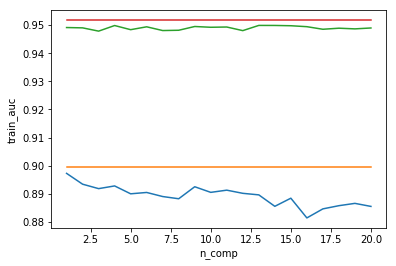

In [0]:
sns.lineplot(data=table, x='n_comp', y='valid_auc')
sns.lineplot(data=table, x='n_comp', y=0.89937)
sns.lineplot(data=table, x='n_comp', y='train_auc')
sns.lineplot(data=table, x='n_comp', y=0.951749)
plt.show()

# Seems like most linera space reduction techiniques doesn't provide any score impovement 
# n_comp = 6 for MCC score
# n_comp = 1 for logloss score
# n_comp = 1 for AUC score
# We put MCC score over the others

In [0]:
pca = PCA(n_components=6)
vPCA_transformed_train = pd.DataFrame(pca.fit_transform(X_train.loc[:, 'V1':'V339']), columns=[f'vPCA_{x}' for x in range(6)])
vPCA_transformed_test = pd.DataFrame(pca.transform(X_test.loc[:, 'V1':'V339']), columns=[f'vPCA_{x}' for x in range(6)])
X_train = X_train.drop(X_train.loc[:, 'V1':'V339'].columns, axis=1)
X_test = X_test.drop(X_test.loc[:, 'V1':'V339'].columns, axis=1)
X_train = X_train.join(vPCA_transformed_train)
X_test = X_test.join(vPCA_transformed_test)

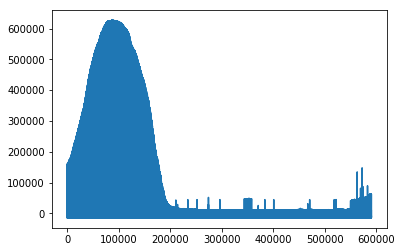

In [0]:
plt.plot(X_train['vPCA_0'])
plt.show()

In [0]:
# Apply Scaler
%%time
vpca_cols = [f'vPCA_{x}' for x in range(6)]
scaler = RobustScaler()

def robust_scalar(df_train: pd.DataFrame, df_test: pd.DataFrame, cols=List[str]):
    df_train[cols] = scaler.fit_transform(df_train[cols])
    df_test[cols] = scaler.transform(df_test[cols])
robust_scalar(X_train, X_test, vpca_cols)

number_cols = list(set(X_train.columns) - set(cat_cols))
number_cols

bst = train_val_score(X_train, y_train)

CPU times: user 1.52 s, sys: 183 ms, total: 1.7 s
Wall time: 1.71 s


In [0]:
bst = train_val_score(X_train, y_train)
# Submit base model to lb
# --------------------------------------------------------------------------------------------- #
y_test = bst.predict(X_test)
submission = np.vstack([y_test_id['TransactionID'], y_test])
submission = pd.DataFrame(submission.T, columns=['TransactionID', 'isFraud'])
submission['TransactionID'] = submission['TransactionID'].astype(int) 
submission.to_csv(f'{root_path}submission.csv', index=False)
!kaggle competitions submit -c ieee-fraud-detection -f '{root_path}submission.csv' -m "vPCA model"
# --------------------------------------------------------------------------------------------- #

100% 13.9M/13.9M [00:02<00:00, 7.22MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [0]:
validation_scores = append_scores(validation_scores, bst, 'vPCA_2', 0.9087)

In [0]:
X_train.to_csv(f'{root_path}x_train.csv')
X_test.to_csv(f'{root_path}x_test.csv')
validation_scores.to_csv(f'{root_path}validation_scores')
number_cols.to_csv(f'{root_path}number_cols.csv')

#### Discirminant Analys for V-features
```
No improvement
```

In [0]:
lda = LinearDiscriminantAnalysis()
clf_decompositors = [lda]

def v_feature_discriminant_analysis(clfs, number):
    scores = pd.DataFrame(columns=['Decompositor', 'n_comp', 'auc', 'binary_logloss'])
    for n in number:
        for clf in clfs:
            clf.n_components = n
            train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.3, shuffle=False, random_state=31)
            v_transformed_train = pd.DataFrame(clf.fit_transform(train_x.loc[:, 'V1':'V339'], train_y), columns=[str(x) for x in range(n)])
            train_x = train_x.drop(train_x.loc[:, 'V1':'V339'].columns, axis=1)
            train_x = train_x.join(v_transformed_train)
            
            v_transformed_test = pd.DataFrame(clf.transform(test_x.loc[:, 'V1':'V339']), columns=[str(x) for x in range(n)])
            test_x = test_x.drop(test_x.loc[:, 'V1':'V339'].columns, axis=1)
            test_x = test_x.join(v_transformed_test)
            

            train_data = lgb.Dataset(train_x, label=train_y, feature_name=train_x.columns.to_list(),
                             categorical_feature=cat_cols)
            validation_data = lgb.Dataset(test_x, label=test_y, feature_name=test_x.columns.to_list(),
                                  categorical_feature=cat_cols, reference=train_data)
            param = {
            'objective': 'binary',
            'num_iterations': 200,
            'learning_rate': 0.05,
            'n_jobs': -1,
            'reg_alpha': 0.1,
            'min_split_gain': 0.1,
            'bagging_fraction': 0.5,
            'bagging_freq': 5,
            'pos_bagging_fraction': 0.5,
            'neg_bagging_fraction': 0.5,
            'feature_fraction': 0.5,
            'verbose': 0,
            'metric': ['auc', 'binary_logloss']
            }

            bst = lgb.train(param, train_data, valid_sets=[validation_data])
            tmp = {}
            tmp['Decompositor'] = str(clf).split('(')[0]
            tmp['n_comp'] = n
            tmp['auc'] = bst.best_score['valid_0']['auc']
            tmp['binary_logloss'] = bst.best_score['valid_0']['binary_logloss']
            scores = scores.append(tmp, ignore_index=True)
    return scores

table = v_feature_discriminant_analysis(clf_decompositors, [1])
print(table)

# Scores even worse

### Numeric features

#### Correlation criteria

In [0]:
def corr_feature_analysis(number):
    scores = pd.DataFrame()
    corr_matrix_number = X_train.loc[:, number_cols].corr().abs()
    upper_number = corr_matrix_number.where(np.triu(np.ones(corr_matrix_number.shape), k=1).astype(np.bool))
    for n in number:
        cols_to_drop_number = [column for column in upper_number.columns if any(upper_number[column] > n)]
        train_x, test_x, train_y, test_y = train_test_split(X_train, y_train, test_size=0.3, shuffle=False, random_state=31)
        train_x = train_x.drop(cols_to_drop_number, axis=1)
        test_x = test_x.drop(cols_to_drop_number, axis=1)
        train_data = lgb.Dataset(train_x, label=train_y, feature_name=train_x.columns.to_list(),
                         categorical_feature=cat_cols)
        validation_data = lgb.Dataset(test_x, label=test_y, feature_name=test_x.columns.to_list(),
                              categorical_feature=cat_cols, reference=train_data)
        param = {
        'objective': 'binary',
        'num_iterations': 200,
        'learning_rate': 0.05,
        'n_jobs': -1,
        'reg_alpha': 0.1,
        'min_split_gain': 0.1,
        'bagging_fraction': 0.5,
        'bagging_freq': 5,
        'pos_bagging_fraction': 0.5,
        'neg_bagging_fraction': 0.5,
        'feature_fraction': 0.5,
        'verbose': 0,
        'metric': ['auc', 'binary_logloss']
        }
        bst = lgb.train(param, train_data, valid_sets=[train_data, validation_data], feval=mcc_eval, verbose_eval=200)
        tmp = {}
        tmp['corr'] = n
        tmp['train_auc'] = bst.best_score['training']['auc']
        tmp['valid_auc'] = bst.best_score['valid_1']['auc']
        tmp['train_binary_logloss'] = bst.best_score['training']['binary_logloss']
        tmp['valid_binary_logloss'] = bst.best_score['valid_1']['binary_logloss']
        tmp['train_mcc'] = bst.best_score['training']['MCC']
        tmp['valid_mcc'] = bst.best_score['valid_1']['MCC']
        scores = scores.append(tmp, ignore_index=True)
    return scores

table = corr_feature_analysis([0.92, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8])

# the most interesting thresholds are 0.92 and 0.85

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's binary_logloss: 0.0694645	training's auc: 0.948159	training's MCC: 0.68246	valid_1's binary_logloss: 0.0934378	valid_1's auc: 0.896382	valid_1's MCC: 0.503076
[200]	training's binary_logloss: 0.0694722	training's auc: 0.948597	training's MCC: 0.681157	valid_1's binary_logloss: 0.0937178	valid_1's auc: 0.896318	valid_1's MCC: 0.492584
[200]	training's binary_logloss: 0.0694722	training's auc: 0.948597	training's MCC: 0.681157	valid_1's binary_logloss: 0.0937178	valid_1's auc: 0.896318	valid_1's MCC: 0.492584
[200]	training's binary_logloss: 0.0694722	training's auc: 0.948597	training's MCC: 0.681157	valid_1's binary_logloss: 0.0937178	valid_1's auc: 0.896318	valid_1's MCC: 0.492584
[200]	training's binary_logloss: 0.0694722	training's auc: 0.948597	training's MCC: 0.681157	valid_1's binary_logloss: 0.0937178	valid_1's auc: 0.896318	valid_1's MCC: 0.492584
[200]	training's binary_logloss: 0.0694722	training's auc: 0.948597	training's MCC: 0.681157	valid_1's binary_loglos

In [0]:
corr_matrix_number = X_train.loc[:, number_cols].corr().abs()
upper_number = corr_matrix_number.where(np.triu(np.ones(corr_matrix_number.shape), k=1).astype(np.bool))
cols_to_drop_number = [column for column in upper_number.columns if any(upper_number[column] > 0.92)]
X_train = X_train.drop(cols_to_drop_number, axis=1)
X_test = X_test.drop(cols_to_drop_number, axis=1)

In [0]:
bst = train_val_score(X_train, y_train)
# Submit base model to lb
# --------------------------------------------------------------------------------------------- #
y_test = bst.predict(X_test)
submission = np.vstack([y_test_id['TransactionID'], y_test])
submission = pd.DataFrame(submission.T, columns=['TransactionID', 'isFraud'])
submission['TransactionID'] = submission['TransactionID'].astype(int) 
submission.to_csv(f'{root_path}submission.csv', index=False)
!kaggle competitions submit -c ieee-fraud-detection -f '{root_path}submission.csv' -m "vPCA model"
# --------------------------------------------------------------------------------------------- #

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[200]	training's binary_logloss: 0.0694645	training's auc: 0.948159	training's MCC: 0.68246	valid_1's binary_logloss: 0.0934378	valid_1's auc: 0.896382	valid_1's MCC: 0.503076
100% 13.9M/13.9M [00:02<00:00, 6.02MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [0]:
validation_scores = append_scores(validation_scores, bst, 'Correlated_feat_rem_2', 0.9088)

#### Anova

In [0]:
Fvalue_selector = SelectKBest(f_classif, k=len(number_cols))
Fvalue_selector.fit_transform(X_train.loc[:, number_cols], y_train)
df_Fvalue = pd.DataFrame(Fvalue_selector.scores_, columns=['F-value'])
df_Fvalue['columns'] = number_cols
df_Fvalue = df_Fvalue.sort_values(by='F-value', ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


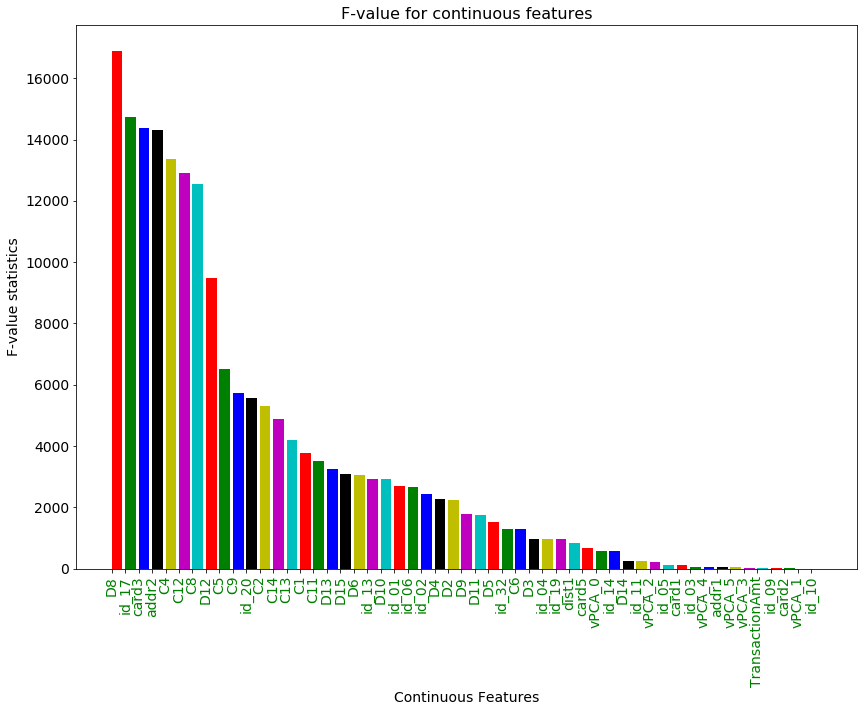

In [0]:
plt.figure(figsize=(14, 10))
plt.title("F-value for continuous features", fontsize=16)
plt.xlabel("Continuous Features", fontsize=14)
plt.ylabel("F-value statistics", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.bar(range(len(df_Fvalue)), df_Fvalue['F-value'], align='edge', color='rgbkymc')
plt.xticks(range(len(df_Fvalue)), df_Fvalue['columns'], rotation=90, color='g')
plt.show()

### Categorical features

#### Chi-square

In [0]:
chi_selector = SelectKBest(chi2, k=len(cat_cols))
chi_selector.fit_transform(X_train.loc[:, cat_cols], y_train)
df_chi = pd.DataFrame(chi_selector.scores_, columns=['chi_score'])
df_chi['columns_name'] = cat_cols
df_chi = df_chi.sort_values(by=['chi_score'], ascending=True)

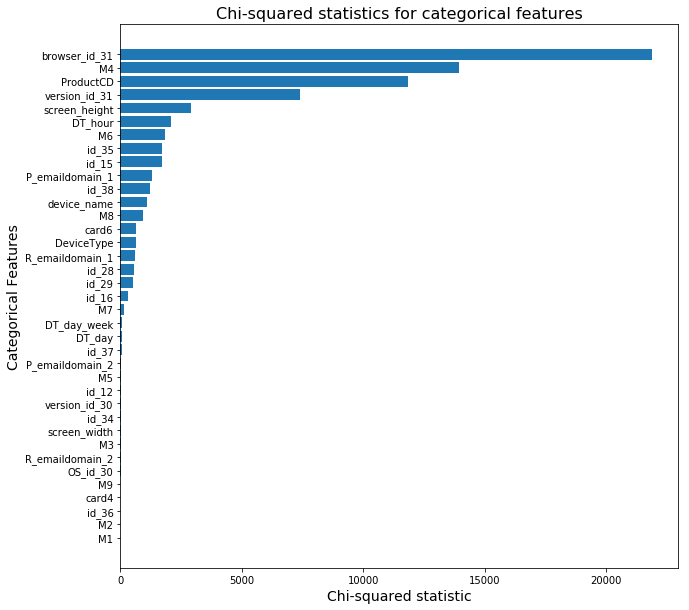

In [0]:
fig,ax=plt.subplots(figsize=(10,  10))
plt.title("Chi-squared statistics for categorical features", fontsize=16)
plt.ylabel("Categorical Features", fontsize=14)
plt.xlabel("Chi-squared statistic", fontsize=14)
plt.barh(range(len(df_chi['chi_score'])), df_chi['chi_score'])
plt.yticks(range(len(df_chi['chi_score'])), df_chi['columns_name'], fontsize=10)
plt.show()

In [0]:
print('Feature with Chi-square statistic less than 1:', len(df_chi[df_chi['chi_score'] < 1]['columns_name']))
cols_to_drop_cat = df_chi[df_chi['chi_score'] < 1]['columns_name'].to_list()
X_train = X_train.drop(cols_to_drop_cat, axis=1)
X_test = X_test.drop(cols_to_drop_cat, axis=1)

Feature with Chi-square statistic less than 1: 3


### CatBoost

In [0]:
# https://github.com/catboost/tutorials/blob/master/feature_selection/eval_tutorial.ipynb

## Oversample

In [0]:
# https://www.kaggle.com/shahules/tackling-class-imbalance 

## Feature elimination

In [0]:
# https://www.kaggle.com/nroman/recursive-feature-elimination
# Lasso RegressionCV

## PCA for V features

In [0]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt

# Models

## Prediction

In [0]:
z = pd.concat([X_test['TransactionID'], pd.Series(np.zeros(X_test.shape[0]))], axis=1, keys=['TransactionID', 'isFraud'])

## Models performace comparison

In [0]:
# https://github.com/manifoldai/mf-eng-public/blob/master/notebooks/custom_loss_lightgbm.ipynb

# Submission

In [0]:
# Submit base model to lb
# --------------------------------------------------------------------------------------------- #
y_test = bst.predict(X_test)
submission = np.vstack([y_test_id['TransactionID'], y_test])
submission = pd.DataFrame(submission.T, columns=['TransactionID', 'isFraud'])
submission['TransactionID'] = submission['TransactionID'].astype(int) 
submission.to_csv(f'{root_path}submission.csv', index=False)
!kaggle competitions submit -c ieee-fraud-detection -f '{root_path}submission.csv' -m "Base model"
# --------------------------------------------------------------------------------------------- #

100% 13.9M/13.9M [00:02<00:00, 7.21MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

# Save Data

In [32]:
%%time
# SAVE
# ------------------------------------------------- #
cat_cols = pd.Series(cat_cols)
number_cols = pd.Series(number_cols)
cat_cols.to_csv(f'{root_path}cat_cols.csv')
number_cols.to_csv(f'{root_path}number_cols.csv')
y_train.to_csv(f'{root_path}y_train.csv')
X_train.to_csv(f'{root_path}x_train.csv')
X_test.to_csv(f'{root_path}x_test.csv')
# ------------------------------------------------- #

CPU times: user 7min 23s, sys: 5.03 s, total: 7min 28s
Wall time: 7min 40s
